**Waste Segregation Using CNN**

We are revolutionizing waste management by using Convolutional Neural Networks (CNN) to accurately sort plastics, paper, metals,Glass,Cardboard,Trash.Once integrated into smart bins and recycling centers, it will transform waste management and propel us toward a sustainable future.

<img src="download.jpg" width="500" height="300">

**Importing Essential Libraries**

In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [6]:
IMAGE_SIZE_HEIGHT=384
IMAGE_SIZE_WIDTH=512
BATCH_SIZE=32
CHANNELS=3

* Loading the Images as the tensor.data.Dataset

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset-resized",
    shuffle=True,
    image_size=(IMAGE_SIZE_WIDTH,IMAGE_SIZE_HEIGHT),
    batch_size=(BATCH_SIZE)
)

Found 2528 files belonging to 6 classes.


In [9]:
len(dataset)

79

In [10]:
class_names=dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[199.    195.    183.   ]
  [199.    195.    183.   ]
  [199.    195.    183.   ]
  ...
  [143.    136.    126.   ]
  [143.    136.    126.   ]
  [143.    136.    126.   ]]

 [[198.375 194.375 182.375]
  [198.375 194.375 182.375]
  [198.375 194.375 182.375]
  ...
  [143.    136.    126.   ]
  [143.    136.    126.   ]
  [143.    136.    126.   ]]

 [[198.    194.    182.   ]
  [198.    194.    182.   ]
  [198.    194.    182.   ]
  ...
  [143.    136.    126.   ]
  [143.    136.    126.   ]
  [143.    136.    126.   ]]

 ...

 [[249.    247.    235.   ]
  [249.    247.    235.   ]
  [249.    247.    235.   ]
  ...
  [156.    150.    138.   ]
  [156.    150.    138.   ]
  [156.    150.    138.   ]]

 [[249.    247.    235.   ]
  [249.    247.    235.   ]
  [249.    247.    235.   ]
  ...
  [155.625 149.625 137.625]
  [155.625 149.625 137.625]
  [155.625 149.625 137.625]]

 [[249.    247.    235.   ]
  [249.    247.    235.   ]
  [249.    247.    235.   ]
  ...
  [155.    14

In [12]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 512, 384, 3)
[1 1 1 3 3 3 4 3 4 4 3 2 3 1 5 1 3 4 2 0 4 1 3 2 1 3 2 2 0 0 1 3]


In [13]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[242.83333 241.83333 246.83333]
  [242.      241.      246.     ]
  [242.      241.      246.     ]
  ...
  [186.83331 182.83331 179.83331]
  [185.      181.      178.     ]
  [184.      180.      177.     ]]

 [[242.83333 241.83333 246.83333]
  [242.      241.      246.     ]
  [242.      241.      246.     ]
  ...
  [186.83331 182.83331 179.83331]
  [185.      181.      178.     ]
  [184.      180.      177.     ]]

 [[242.83333 241.83333 246.83333]
  [242.      241.      246.     ]
  [242.      241.      246.     ]
  ...
  [186.83331 182.83331 179.83331]
  [185.      181.      178.     ]
  [184.      180.      177.     ]]

 ...

 [[225.83333 222.83333 217.83333]
  [225.      222.      217.     ]
  [225.      222.      217.     ]
  ...
  [148.      147.      143.     ]
  [148.      147.      143.     ]
  [148.      147.      143.     ]]

 [[225.83333 222.83333 217.83333]
  [225.      222.      217.     ]
  [225.      222.      217.     ]
  ...
  [148.      147.      143.     ]
  [1

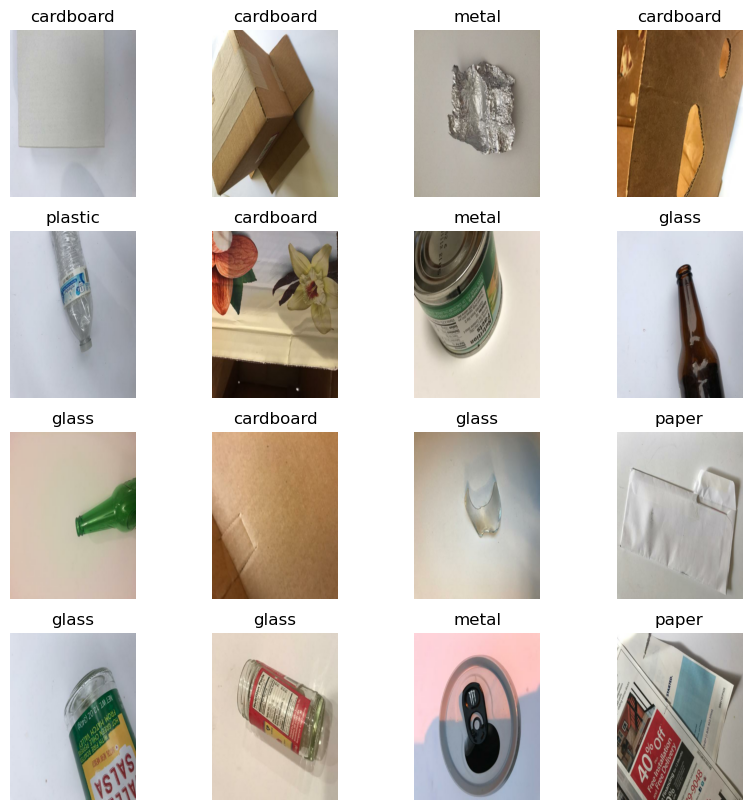

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
print("Training:",len(train_ds),"Validation:",len(val_ds),"Testing:",len(test_ds))

Training: 63 Validation: 7 Testing: 9


* Prefetch:Overlaps data loading with model training, meaning while the model is training on one batch, the next batch is already being prepared.

* Cache:Stores the dataset in memory or disk, so data is loaded only once instead of reading from disk multiple times.

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

* Resizing is done because the user can Provide Input of any dimension image, and Scaling is Done to Normalize the Values the Betweeen 0-1

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE_WIDTH,IMAGE_SIZE_HEIGHT),
    layers.Rescaling(1.0/255)
])

* Data Augmentation as the CNN By Itself Does not Take Care of Rotation and Scaling 

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),       # Flip images horizontally
    layers.RandomRotation(0.2),            # Rotate images by 20%
    layers.RandomZoom(0.2),                # Zoom images by 20%
    layers.RandomBrightness(0.2),          # Adjust brightness
    layers.RandomContrast(0.2),            # Adjust contrast
    layers.RandomTranslation(0.2, 0.2)# Shift images by 20%
])

**CNN MODEL**

In [26]:
for image_batch,label_batch in train_ds.take(1):
    print(image_batch.shape)

(32, 512, 384, 3)


In [27]:
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [28]:
input_shape=(BATCH_SIZE,IMAGE_SIZE_WIDTH,IMAGE_SIZE_HEIGHT,CHANNELS)

In [29]:
len(class_names)

6

In [30]:
classes=6

In [31]:
import warnings 
warnings.filterwarnings('ignore')

In [32]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(512,384, 3),
                                               include_top=False,
                                               weights="imagenet")
base_model.trainable = False  # Freeze base layers

model = tf.keras.Sequential([
    data_augmentation,  # Apply Data Augmentation
    resize_and_rescale, # Apply Resizing and Rescaling
    base_model,         # Pass to Pretrained Model
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 16, 12, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Start with 20 epochs, adjust based on performance
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.2652 - loss: 1.7591 - val_accuracy: 0.6384 - val_loss: 1.1689
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5034 - loss: 1.2820 - val_accuracy: 0.7232 - val_loss: 0.9256
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5916 - loss: 1.1021 - val_accuracy: 0.7768 - val_loss: 0.7971
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6443 - loss: 0.9734 - val_accuracy: 0.7545 - val_loss: 0.7327
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6550 - loss: 0.9515 - val_accuracy: 0.7812 - val_loss: 0.6921
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6743 - loss: 0.9000 - val_accuracy: 0.7812 - val_loss: 0.6452
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6811 - loss: 0.8393 - val_accuracy: 0.7946 - val_loss: 0.6136
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6986 - loss: 0.8005 - val_accuracy: 0.8170 - v

In [35]:
scores=model.evaluate(test_ds)
scores

9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8088 - loss: 0.4651


[0.4194108247756958, 0.8298611044883728]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 63}

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


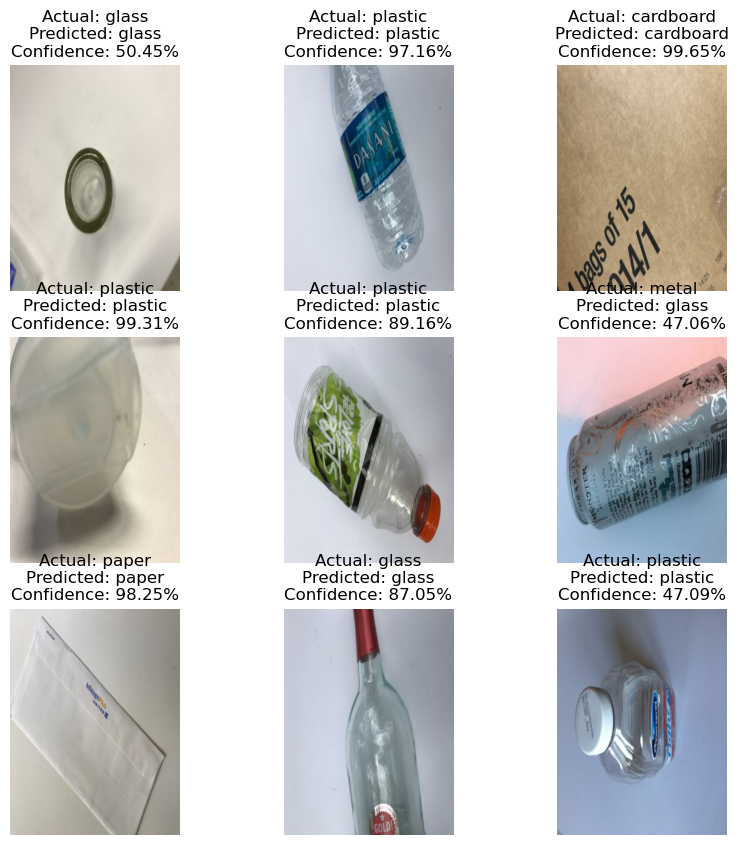

In [39]:
def predict(model, img):
    # Convert image to tensor if it's not already
    if not isinstance(img, tf.Tensor):
        img = tf.convert_to_tensor(img)

    img_array = tf.keras.preprocessing.image.img_to_array(img)  # No need for .numpy()
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions for batch
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

# Plot images and predictions
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))  # Convert tensor to NumPy for display
        
        predict_class, confidence = predict(model, images[i])  # Pass tensor directly (Fix)
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predict_class}\nConfidence: {confidence}%")
        plt.axis('off')

plt.show()

In [40]:
model.save("../models/waste_segregation.keras")